In [1]:
# Change to the desired directory
import os
from IPython import get_ipython
if __name__ == "__main__":
    # Specify the target directory
    target_dir = r"E:\Github\pneumonia_vs_normal_with_mlflow"

    # Use %cd to change directory
    get_ipython().run_line_magic('cd', target_dir)

E:\Github\pneumonia_vs_normal_with_mlflow


# Importing Libraries

In [2]:
import pandas as pd
import numpy as np 
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler


# Creating a datamap

## Data maps is just a DataFrame made up from all the data we have (pictures in our case)

In [3]:
paths = [r'data\chest_xray\test\NORMAL',
         r'data\chest_xray\test\PNEUMONIA',
         r'data\chest_xray\train\NORMAL',
         r'data\chest_xray\train\PNEUMONIA',
         r'data\chest_xray\val\NORMAL',
         r'data\chest_xray\val\PNEUMONIA']

# Create a list of all image paths and their corresponding classes and splits
# Initialize an empty list to store DataFrames
df_list = []

for path in paths:
    img_path = glob(path + r'\*.jpeg')
    clas = Path(path).name
    split = Path(path).parent.name
    print(f"Found {len(img_path)} images in: {path}")

    df_loop = pd.DataFrame({
        'img_path': img_path,
        'clas': clas,
        'split': split
    })
    # Append the DataFrame to the list
    df_list.append(df_loop)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(df_list, ignore_index=True)    


Found 234 images in: data\chest_xray\test\NORMAL
Found 390 images in: data\chest_xray\test\PNEUMONIA
Found 1341 images in: data\chest_xray\train\NORMAL
Found 3875 images in: data\chest_xray\train\PNEUMONIA
Found 8 images in: data\chest_xray\val\NORMAL
Found 8 images in: data\chest_xray\val\PNEUMONIA


In [4]:
df

,img_path,clas,split
0,data\chest_xray\test\NORMAL\IM-0001-0001.jpeg,NORMAL,test
1,data\chest_xray\test\NORMAL\IM-0003-0001.jpeg,NORMAL,test
2,data\chest_xray\test\NORMAL\IM-0005-0001.jpeg,NORMAL,test
3,data\chest_xray\test\NORMAL\IM-0006-0001.jpeg,NORMAL,test
4,data\chest_xray\test\NORMAL\IM-0007-0001.jpeg,NORMAL,test
...,...,...,...
5851,data\chest_xray\val\PNEUMONIA\person1949_bacte...,PNEUMONIA,val
5852,data\chest_xray\val\PNEUMONIA\person1950_bacte...,PNEUMONIA,val
5853,data\chest_xray\val\PNEUMONIA\person1951_bacte...,PNEUMONIA,val
5854,data\chest_xray\val\PNEUMONIA\person1952_bacte...,PNEUMONIA,val


In [5]:
df['clas'].value_counts(), df['split'].value_counts()

(clas
 PNEUMONIA    4273
 NORMAL       1583
 Name: count, dtype: int64,
 split
 train    5216
 test      624
 val        16
 Name: count, dtype: int64)

# Data Augmentation

In [8]:
from torchvision import transforms
# Augmentation pipeline for NORMAL images
augmentation = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.3)
])

# Augment output dir
aug_output_dir = Path(r"E:\Github\pneumonia_vs_normal_with_mlflow\data\chest_xray_augmented")
aug_output_dir.mkdir(parents=True, exist_ok=True)

# Select only NORMAL training images
df_normal = df[(df['split'] == 'train') & (df['clas'] == 'NORMAL')]

# Number of augmentations per image
num_aug_per_image = 3

augmented_rows = []

print("Augmenting NORMAL images...")
for idx, row in tqdm(df_normal.iterrows(), total=len(df_normal)):
    original_path = row['img_path']
    img = Image.open(original_path).convert("L")

    for i in range(num_aug_per_image):
        aug_img = augmentation(img)
        new_filename = f"{Path(original_path).stem}_aug{i}.jpeg"
        new_path = aug_output_dir / new_filename

        aug_img.save(new_path)

        augmented_rows.append({
            'img_path': str(new_path),
            'split': 'train',
            'clas': 'NORMAL'
        })

# Add augmented samples to df
df_augmented = pd.DataFrame(augmented_rows)
df = pd.concat([df, df_augmented], ignore_index=True)

Augmenting NORMAL images...


100%|██████████| 1341/1341 [01:37<00:00, 13.76it/s]


In [9]:
df.head()

,img_path,clas,split
0,data\chest_xray\test\NORMAL\IM-0001-0001.jpeg,NORMAL,test
1,data\chest_xray\test\NORMAL\IM-0003-0001.jpeg,NORMAL,test
2,data\chest_xray\test\NORMAL\IM-0005-0001.jpeg,NORMAL,test
3,data\chest_xray\test\NORMAL\IM-0006-0001.jpeg,NORMAL,test
4,data\chest_xray\test\NORMAL\IM-0007-0001.jpeg,NORMAL,test


In [10]:
df['split'].value_counts()

split
train    9239
test      624
val        16
Name: count, dtype: int64

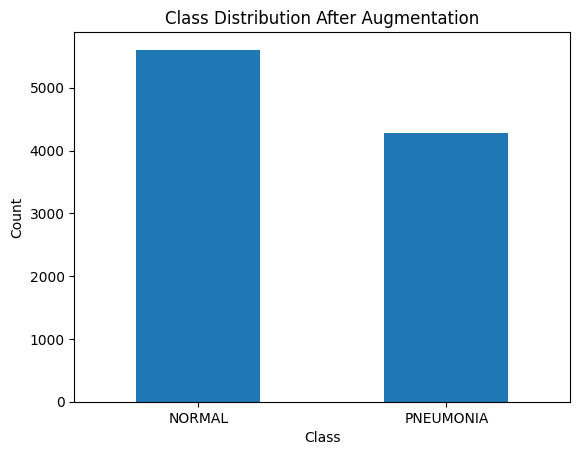

In [11]:
df['clas'].value_counts().plot(kind='bar')
plt.title('Class Distribution After Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

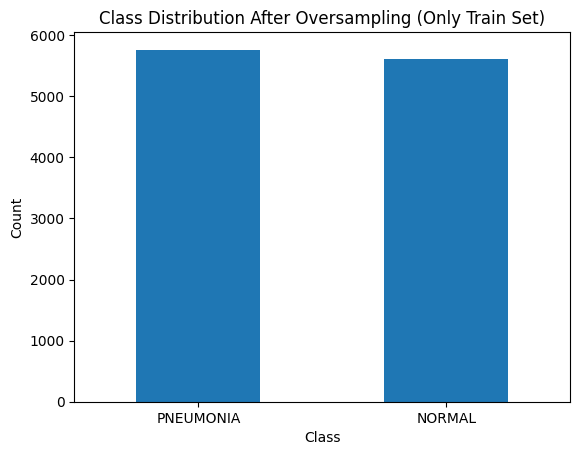

In [12]:
# Split original dataset
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']
val_df = df[df['split'] == 'val']

# Apply RandomOverSampler to train only
ros = RandomOverSampler(random_state=42)
X = train_df[['img_path']]
y = train_df['clas']
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled = pd.Series(y_resampled, name='clas')
train_df_oversampled = pd.concat([X_resampled, y_resampled], axis=1)
train_df_oversampled['split'] = 'train'

# Combine everything back
df_balanced = pd.concat([train_df_oversampled, test_df, val_df], ignore_index=True)

# Plot the new distribution
df_balanced['clas'].value_counts().plot(kind='bar')
plt.title('Class Distribution After Oversampling (Only Train Set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()


# Resizing our images so they are constant around 224x224 pixels

224x224 pixels is one of the default input sizes in most transform learning models

## Creaing a subplot to show the variations in our input sizes

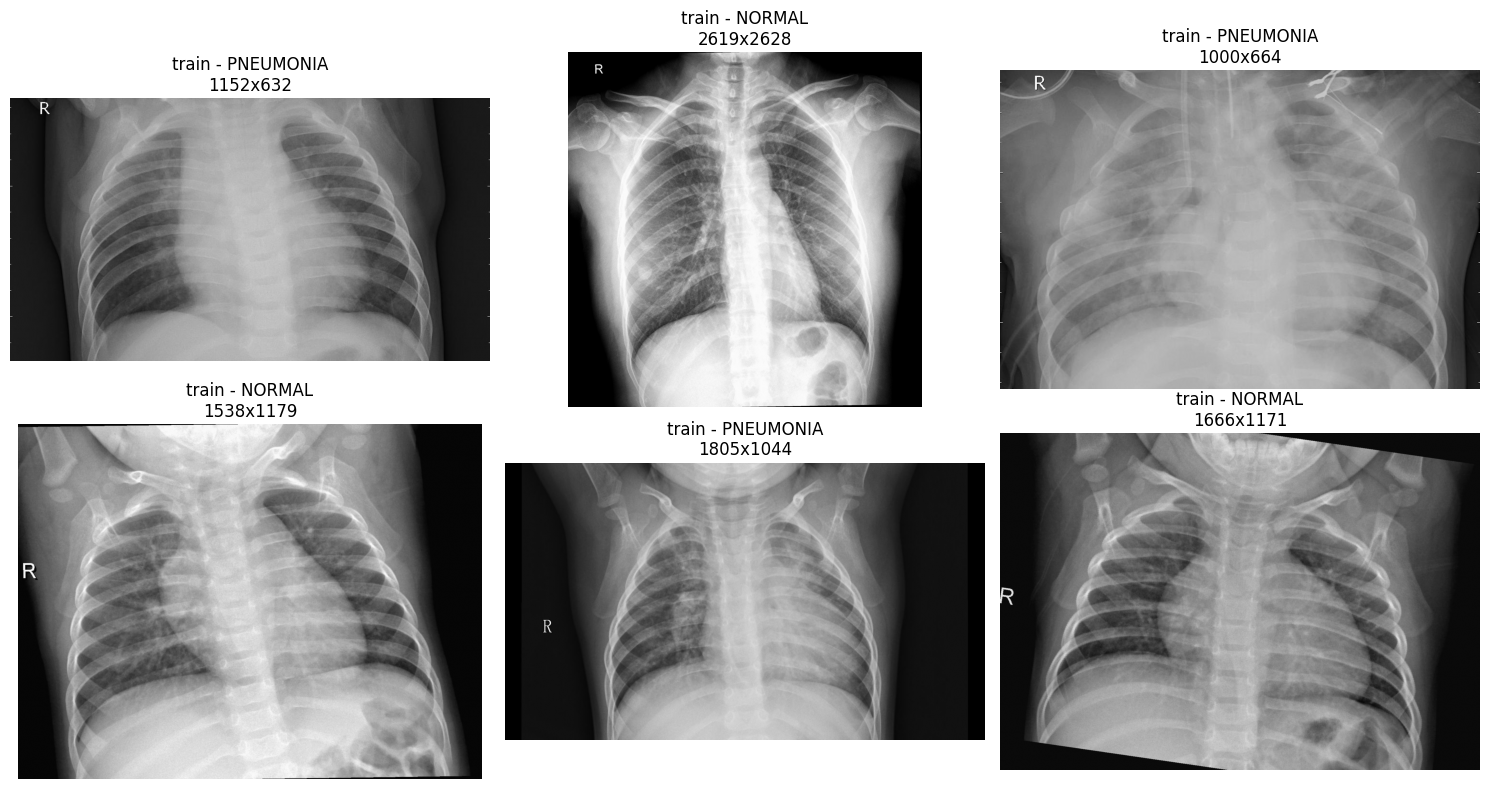

In [13]:
# Sample 6 random images from the DataFrame
sample_df = df.sample(6)

# Set up a subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):
    img = Image.open(row['img_path'])
    ax.imshow(img, cmap='gray')  # Chest X-rays are grayscale
    ax.set_title(f"{row['split']} - {row['clas']}\n{img.size[0]}x{img.size[1]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Resizing Process

In [14]:
# Parameters
resize_to = 256
crop_size = 224
base_output_dir = Path('data/chest_xray_resized')
base_output_dir.mkdir(parents=True, exist_ok=True)

# Resize & crop function
def resize_and_crop_center(image_path, resize_to, crop_size):
    img = Image.open(image_path).convert("L")
    img = img.resize((resize_to, resize_to))
    left = (resize_to - crop_size) // 2
    top = (resize_to - crop_size) // 2
    return img.crop((left, top, left + crop_size, top + crop_size))

# Store new paths
resized_paths = []

print("Resizing and cropping images...")
for i in tqdm(range(len(df))):
    original_path = Path(df.loc[i, 'img_path'])
    split = df.loc[i, 'split']
    clas = df.loc[i, 'clas']

    output_subdir = base_output_dir / split / clas
    output_subdir.mkdir(parents=True, exist_ok=True)

    new_filename = f"{original_path.stem}_resized{original_path.suffix}"
    new_path = output_subdir / new_filename

    img = resize_and_crop_center(original_path, resize_to, crop_size)
    img.save(new_path)

    resized_paths.append(str(new_path))

df['resized_path'] = resized_paths

Resizing and cropping images...


100%|██████████| 9879/9879 [01:24<00:00, 116.95it/s]


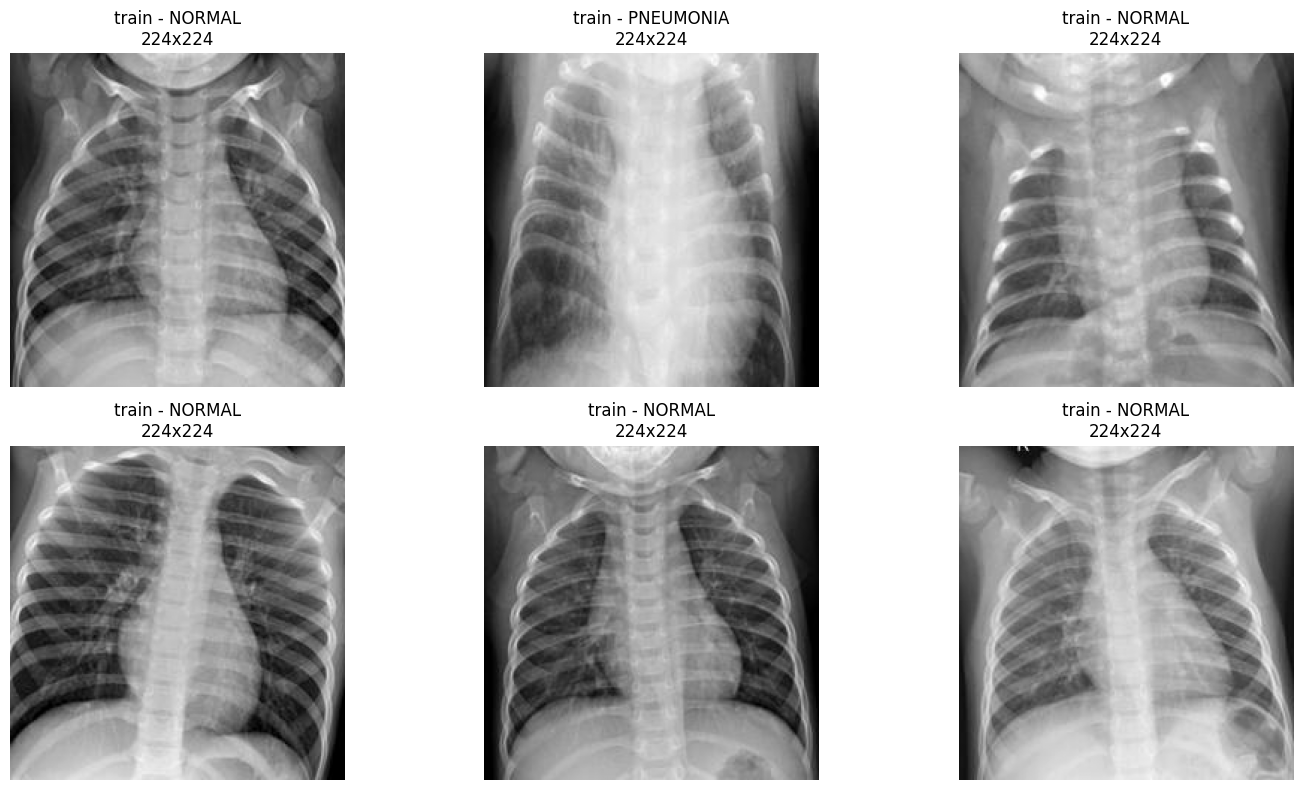

In [15]:
# Sample 6 random images from the DataFrame
sample_df = df.sample(6)

# Set up a subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):
    img = Image.open(row['resized_path'])
    ax.imshow(img, cmap='gray')  # Chest X-rays are grayscale
    ax.set_title(f"{row['split']} - {row['clas']}\n{img.size[0]}x{img.size[1]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualizing the images after resizing

# Saving the dataframe as a csv file

In [16]:
df.to_csv(r'df_resized.csv', index=False)